<a href="https://colab.research.google.com/github/arjan-hada/protein-variant-prediction/blob/master/01_protein_seq2fxn_finetune_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install for running in colab
!pip install evaluate datasets transformers[torch] &> /dev/null
!apt install git-lfs &> /dev/null

In [ ]:
# To share your model with the community
# First store your authentication token from the Hugging Face website and then execute this cell
# Make sure to get token with WRITE access
from huggingface_hub import notebook_login

notebook_login()

# Fine-Tuning Transformers for protein sequence-to-function modeling

In the previous notebook [**Learning sequence-to-function relationship using language models**](https://github.com/arjan-hada/protein-variant-prediction/blob/master/00_protein_seq_to_fxn_model.ipynb), we built a protein sequence-to-function model by training a regressor on embedding from transformers protein language model. We froze the pretrained transformers body's weights during training and used the hidden states as fixed features for the regressor.

In this notebook, we will employ transfer learning to fine-tune pre-trained protein language models for specific tasks of interest. The entire model will be trained end-to-end, avoiding the use of fixed hidden states as features. This necessitates a differentiable classification head, which is why the method incorporates a neural network for regression purposes.

**Goals**

- Fine-tune a large protein language model on deep mutational scanning (DMS) data and use it for inference.

## Load the data

The following data originated from the "Data processing" section of the prior notebook titled "[Learning protein sequence-function relationship from Deep Mutational Scanning data.](https://github.com/arjan-hada/protein-variant-prediction/blob/master/00_protein_seq_to_fxn_model.ipynb)" It stems from the original [Deep Mutational Scanning (DMS) data](https://raw.githubusercontent.com/churchlab/aav_rep_scan/master/analysis/selection_values/wtaav2_selection_values_barcode.csv) associated with the "Comprehensive mutagenesis maps the effect of all single codon mutations in the AAV2 rep gene on AAV production" paper, which was published in 2023 by the George M. Church lab [DOI: 10.7554/eLife.87730.1](https://doi.org/10.7554/eLife.87730.1). The published data underwent transformation to generate essential columns for sequence-to-function modeling.

In [ ]:
# Import libraries
from pathlib import Path
import os
import pickle

import numpy as np
import pandas as pd
import re
from functools import partial

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context(context="paper", font_scale=1.5)

In [ ]:
# Load the Rep78 DMS data for supervised training saved as pkl file
# fitness_by_mutation_wtaav2 = 'https://github.com/arjan-hada/protein-variant-prediction/blob/master/data/fitness_by_mutation_wtaav2.pkl'

with open('data/fitness_by_mutation_wtaav2.pkl', 'rb') as f: fitness_by_mutation = pickle.load(f)
fitness_by_mutation.head()

,aa_mutations,fitness_values,sequence,num_fitval,median_fitness,std,log10_fitness
-1,,"[1.3654886776236974, 0.9051534794854056, 0.962...",MPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...,6160,0.916780,0.500121,-0.037735
0,M1A,"[0.804230443445221, 1.3311503154654416, 0.5935...",APGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...,16,0.665872,0.225537,-0.176609
1,M1C,"[0.4306736088980122, 0.6045132166563244, 0.376...",CPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...,8,0.635274,0.338759,-0.197039
2,M1D,"[0.4196620677614153, 1.215491815308973, 0.5495...",DPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...,8,0.925596,0.433922,-0.033579
3,M1E,"[0.4396459757500541, 0.7602211664011352, 0.206...",EPGFYEIVIKVPSDLDGHLPGISDSFVNWVAEKEWELPPDSDMDLN...,8,0.578925,0.308326,-0.237378


Brief description of the columns in the dataset:

**`aa_mutations`**: Indicates amino acid mutations, where, for example, "M1A" signifies a change from amino acid "M" at position 1 to amino acid "A". A blank line at row index -1 denotes no amino acid mutation, representing the wild-type sequence.

**`fitness_values`**: Represents the fitness values corresponding to each protein variant.

**`sequence`**: Displays the wild-type protein sequence at index -1 and mutated protein sequences for all other indices.

**`num_fitval`**: Indicates the number of fitness values associated with each protein variant.

**`median_fitness`**: Represents the median of the num_fitval column.

**`std`**: Signifies the standard deviation of the num_fitval column.

**`log10_fitness`**: Reflects the log10 transformation of the median_fitness column.


## Data normalization

The dataset exhibits substantial noise, inherent to high-throughput measurements. In the modeling phase, we streamline our approach by exclusively utilizing the median fitness value for amino acid substitutions spanning the entire protein length. We also perform transformation to normalize the median fitness value such that wildtype fitness corresponds to a value of 1.

In [ ]:
# median_fitness_wt value is used to normalize the entire dataset
# such that wt fitness corresponds to a value of 1
median_fitness_wt = fitness_by_mutation.loc[-1, 'median_fitness']

sequences = fitness_by_mutation["sequence"].tolist()
fitness = fitness_by_mutation.loc[:, 'median_fitness'].values # obtain target

# transformation to normalize WT fitness value to 1
fitness_norm = (fitness - np.min(fitness))/(median_fitness_wt -np.min(fitness))

<ipython-input-6-480de4d29ac9>:1: RuntimeWarning: divide by zero encountered in log10
  sns.histplot(np.log10(fitness_by_mutation['median_fitness'].values), kde=True)


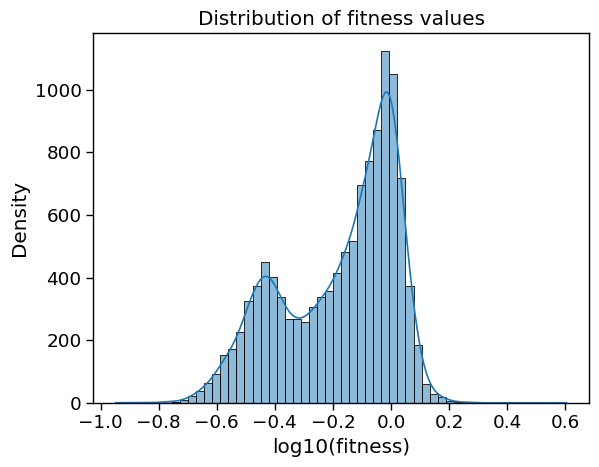

In [ ]:
sns.histplot(np.log10(fitness_by_mutation['median_fitness'].values), kde=True)
plt.xlabel('log10(fitness)')
plt.ylabel('Density')
plt.title("Distribution of fitness values");

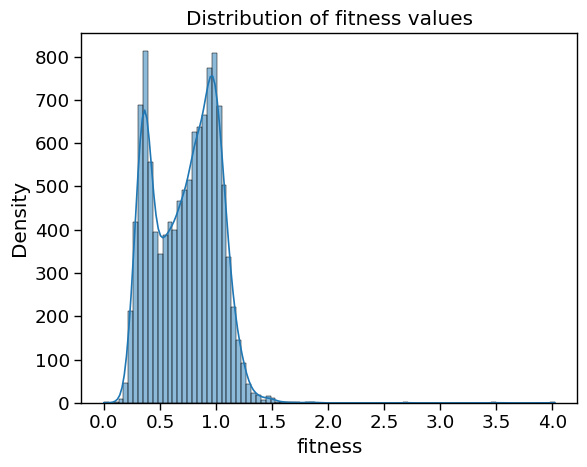

In [ ]:
sns.histplot(fitness_by_mutation['median_fitness'].values, kde=True)
plt.xlabel('fitness')
plt.ylabel('Density')
plt.title("Distribution of fitness values");

## Splitting the data

In machine learning, the train-test split is a vital practice involving the division of a dataset into two subsets: the training set, used to train the model, and the test set, employed to evaluate the model's performance on unseen data. This separation ensures that the model is not simply memorizing the training data but can generalize well to new examples. Achieving the right balance in data allocation is crucial for effective model training and evaluation, fostering reliable insights into its real-world applicability.

In [ ]:
from sklearn.model_selection import train_test_split

train_sequences, test_sequences, train_labels, test_labels = train_test_split(sequences, fitness_norm,
                                                                              test_size=0.2, random_state=42)

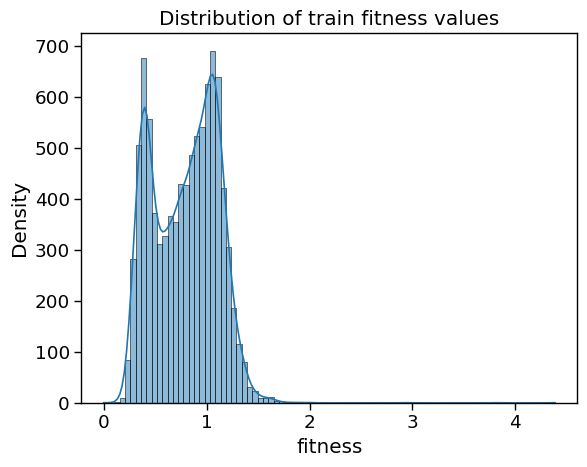

In [ ]:
sns.histplot(train_labels, kde=True)
plt.xlabel('fitness')
plt.ylabel('Density')
plt.title("Distribution of train fitness values");

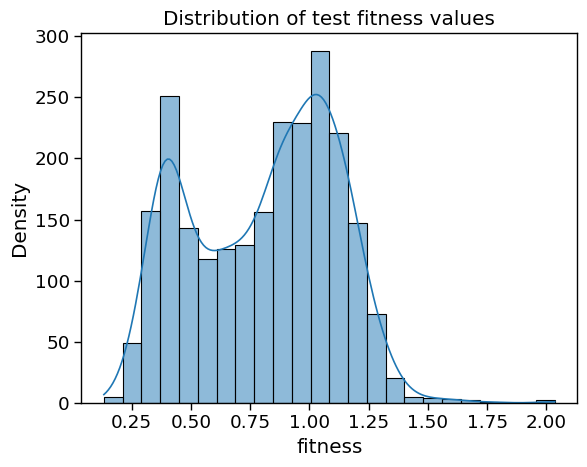

In [ ]:
sns.histplot(test_labels, kde=True)
plt.xlabel('fitness')
plt.ylabel('Density')
plt.title("Distribution of test fitness values");

## Tokenizing the data

Data tokenization in protein language models entails breaking down protein sequences into numerical indices, or tokens, to enable input to nueral network. These tokens, often corresponding to individual amino acids or short sequences, allow the model to capture intricate patterns in protein structures. Every model on `transformers` comes with an associated `tokenizer` that handles tokenization for it. This holds true for protein language models as well.

In [ ]:
model_checkpoint = "facebook/esm2_t12_35M_UR50D"

In [ ]:
# The AutoTokenizer class automatically retrieve the model's configuration, pretrained weights,
# or vocabulary from the name of the checkpoint.
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
tokenizer(train_sequences[0])

{'input_ids': [0, 20, 14, 6, 18, 19, 9, 12, 7, 12, 15, 7, 14, 8, 13, 4, 13, 6, 21, 4, 14, 6, 12, 8, 13, 8, 18, 7, 17, 22, 7, 5, 9, 15, 9, 22, 9, 4, 14, 14, 13, 8, 13, 20, 13, 4, 17, 4, 12, 9, 16, 5, 14, 4, 11, 7, 5, 9, 15, 4, 16, 10, 13, 18, 4, 11, 9, 22, 10, 10, 7, 8, 15, 5, 14, 9, 5, 4, 18, 18, 7, 16, 18, 9, 15, 6, 9, 8, 19, 18, 21, 20, 21, 7, 4, 7, 9, 11, 11, 6, 7, 15, 8, 20, 7, 4, 6, 10, 18, 4, 8, 16, 12, 10, 9, 15, 4, 12, 16, 10, 12, 19, 10, 6, 12, 9, 14, 11, 4, 14, 17, 22, 18, 5, 7, 11, 15, 11, 10, 17, 6, 5, 6, 6, 6, 17, 15, 7, 7, 13, 9, 23, 19, 12, 14, 17, 19, 4, 4, 14, 15, 11, 16, 14, 9, 4, 16, 22, 5, 22, 11, 17, 20, 9, 16, 19, 4, 8, 5, 23, 4, 17, 4, 11, 9, 10, 15, 10, 4, 7, 5, 16, 21, 4, 11, 21, 7, 8, 16, 11, 16, 9, 16, 17, 15, 9, 17, 16, 17, 14, 17, 8, 13, 5, 14, 7, 12, 10, 8, 15, 11, 8, 5, 10, 19, 20, 9, 4, 7, 6, 22, 4, 7, 13, 15, 6, 12, 11, 8, 9, 15, 16, 22, 12, 16, 9, 13, 16, 5, 8, 19, 12, 8, 18, 17, 5, 5, 8, 17, 8, 10, 8, 16, 12, 15, 5, 5, 4, 13, 17, 5, 6, 15, 12, 20, 8, 

Our sequence has been converted into input_ids, which is the tokenized sequence, and an attention_mask. The purpose of the attention mask is to manage variable-length sequences. In instances of shorter sequences, padding is applied using blank "padding" tokens, and the attention mask is padded with 0s, signaling the model to disregard these tokens during processing.

In [ ]:
train_tokenized = tokenizer(train_sequences)
test_tokenized = tokenizer(test_sequences)

## Pytorch compatible `Dataset` creation

Our next step involves shaping this data into a dataset compatible with PyTorch. To achieve this, we leverage the HuggingFace `Dataset` class.

In [ ]:
from datasets import Dataset
train_ds = Dataset.from_dict(train_tokenized)
test_ds = Dataset.from_dict(test_tokenized)

train_ds

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 9432
})

In [ ]:
train_ds = train_ds.add_column("labels", train_labels)
test_ds = test_ds.add_column("labels", test_labels)
train_ds

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 9432
})

## Fine-tuning Transformers

Fine-tuning a pretrained protein language model involves adjusting the parameters of an existing model that has already been trained on a large dataset. Initially pretrained on a diverse set of protein sequences, the model has learned general features and patterns. Fine-tuning adapts the model to a specific task or dataset by exposing it to a smaller, task-specific dataset. During this process, the model's weights are updated to better capture the nuances and specificities of the new data.

### Loading a pretrained model

Use exactly the same model as you used when loading the tokenizer, or your model might not understand the tokenization scheme you're using!

In [ ]:
import gc
import torch
gc.collect()
torch.cuda.empty_cache()

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=1)

config.json:   0%|          | 0.00/778 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/136M [00:00<?, ?B/s]

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The warnings are signaling that the model is shedding certain weights related to language modeling (specifically, the lm_head) while incorporating new weights for sequence classification (the classifier). This aligns perfectly with our intention to fine-tune a pretrained language model for a distinct task. The reminder is crucial—it underscores the need to fine-tune the model as it isn't directly usable for inference in its current state.

### Defining the performance metrics

In [ ]:
from evaluate import load
import numpy as np

metric_spearmanr = load("spearmanr")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    return {'spearmanr': metric_spearmanr.compute(predictions=predictions, references=labels)}

### Training the model

In [ ]:
torch.cuda.is_available() # check whether a GPU is available or not; use GPU

True

In [ ]:
!export PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:32

In [ ]:
model_name = model_checkpoint.split("/")[-1]

In [ ]:
lr,bs = 2e-5,8
wd,epochs = 0.01,20

args = TrainingArguments(f"{model_name}-finetuned-wtaav2-v0",
                         learning_rate=lr, fp16=True,
                         evaluation_strategy="epoch",
                         save_strategy = "epoch",
                         per_device_train_batch_size=bs,
                         per_device_eval_batch_size=2*bs,
                         num_train_epochs=epochs,
                         weight_decay=wd,
                         load_best_model_at_end=True,
                         push_to_hub=True,)

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train();

Epoch,Training Loss,Validation Loss,Spearmanr
1,0.101300,0.095570,{'spearmanr': 0.3349426786649024}
2,0.097700,0.093780,{'spearmanr': 0.27735458399641416}
3,0.101000,0.092997,{'spearmanr': 0.2059862915552575}
4,0.099500,0.093259,{'spearmanr': 0.3675884120648157}
5,0.099900,0.093964,{'spearmanr': 0.29004250982198826}
6,0.098300,0.093485,{'spearmanr': 0.5768490303216554}
7,0.100200,0.097973,{'spearmanr': 0.4623702982930797}
8,0.101100,0.093476,{'spearmanr': 0.5633494761699351}
9,0.095700,0.093070,{'spearmanr': 0.47882757001211296}
10,0.098400,0.086269,{'spearmanr': 0.6398974575720455}


Trainer is attempting to log a value of "{'spearmanr': 0.3349426786649024}" of type <class 'dict'> for key "eval/spearmanr" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'spearmanr': 0.27735458399641416}" of type <class 'dict'> for key "eval/spearmanr" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'spearmanr': 0.2059862915552575}" of type <class 'dict'> for key "eval/spearmanr" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'spearmanr': 0.3675884120648157}" of type <class 'dict'> for key "eval/spearmanr" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'spearmanr': 0.2900425098

### Plot results

In [ ]:
history = trainer.state.log_history
pd.DataFrame(history).head()

,loss,learning_rate,epoch,step,eval_loss,eval_spearmanr,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,0.1081,0.000020,0.42,500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.1013,0.000019,0.85,1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,1.00,1179,0.09557,{'spearmanr': 0.3349426786649024},15.7387,149.885,9.404,NaN,NaN,NaN,NaN,NaN
3,0.1021,0.000019,1.27,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0977,0.000018,1.70,2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


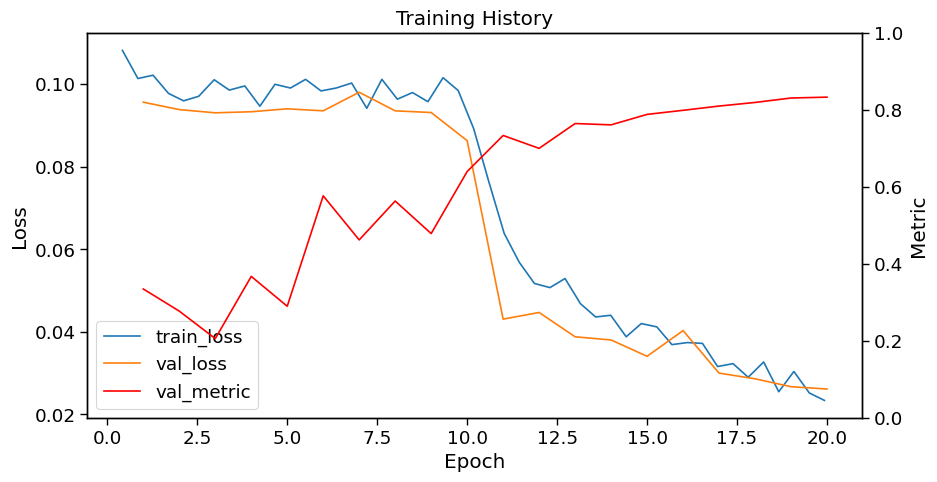

In [ ]:
# code from: https://github.com/agemagician/ProtTrans/blob/master/Fine-Tuning/PT5_LorA_Finetuning_per_prot.ipynb
# Get loss, val_loss, and the computed metric from history
loss = [x['loss'] for x in history if 'loss' in x]
val_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]

# Get spearman (for regression) or accuracy value (for classification)
if [x['eval_spearmanr'] for x in history if 'eval_spearmanr' in x] != []:
    metric = [x['eval_spearmanr']['spearmanr'] for x in history if 'eval_spearmanr' in x]
else:
    metric = [x['eval_accuracy'] for x in history if 'eval_accuracy' in x]

epochs = [x['epoch'] for x in history if 'loss' in x]

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()

# Plot loss and val_loss on the first y-axis
line1 = ax1.plot(epochs, loss, label='train_loss')
line2 = ax1.plot(range(1,21), val_loss, label='val_loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

# Plot the computed metric on the second y-axis
line3 = ax2.plot(range(1,21), metric, color='red', label='val_metric')
ax2.set_ylabel('Metric')
ax2.set_ylim([0, 1])

# Combine the lines from both y-axes and create a single legend
lines = line1 + line2 + line3
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='lower left')

# Show the plot
plt.title("Training History")
plt.show()

### Saving and Loading the finetuned model

In [ ]:
trainer.save_model("models/esm2_t12_35M_UR50D-finetuned-wtaav2-v0")
#model.save_pretrained("path/to/model")

In [ ]:
# save the model to Hugging Face Hub
trainer.push_to_hub(commit_message="Training completed!")

To check if the original and the reloaded models are identical we can compare weights.

In [ ]:
# Put both models to the same device
model=model.to("cpu")
model_reload=AutoModelForSequenceClassification.from_pretrained(
    "models/esm2_t12_35M_UR50D-finetuned-wtaav2-v0").to("cpu")

# Iterate through the parameters of the two models and compare the data
for param1, param2 in zip(model.parameters(), model_reload.parameters()):
    if not torch.equal(param1.data, param2.data):
        print("Models have different weights")
        break
else:
    print("Models have identical weights")

Models have identical weights


### Inference from the model

In [ ]:
test_ds

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 2359
})

In [ ]:
from torch.utils.data import DataLoader
from tqdm import tqdm

# Set the device to use
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# make compatible with torch DataLoader
test_set = test_ds.with_format("torch", device=device)

# Create a dataloader for the test dataset
test_dataloader = DataLoader(test_set, batch_size=16, shuffle=False)

# Put the model in evaluation mode
model.eval()

# Make predictions on the test dataset
predictions = []
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        #add batch results(logits) to predictions
        predictions += model(input_ids, attention_mask=attention_mask).logits.tolist()

100%|██████████| 148/148 [00:14<00:00, 10.55it/s]


In [ ]:
# Regression
from scipy import stats
spearmanr = stats.spearmanr(a=predictions, b=test_ds['labels'], axis=0)
print(spearmanr)

SignificanceResult(statistic=0.833180754394312, pvalue=0.0)


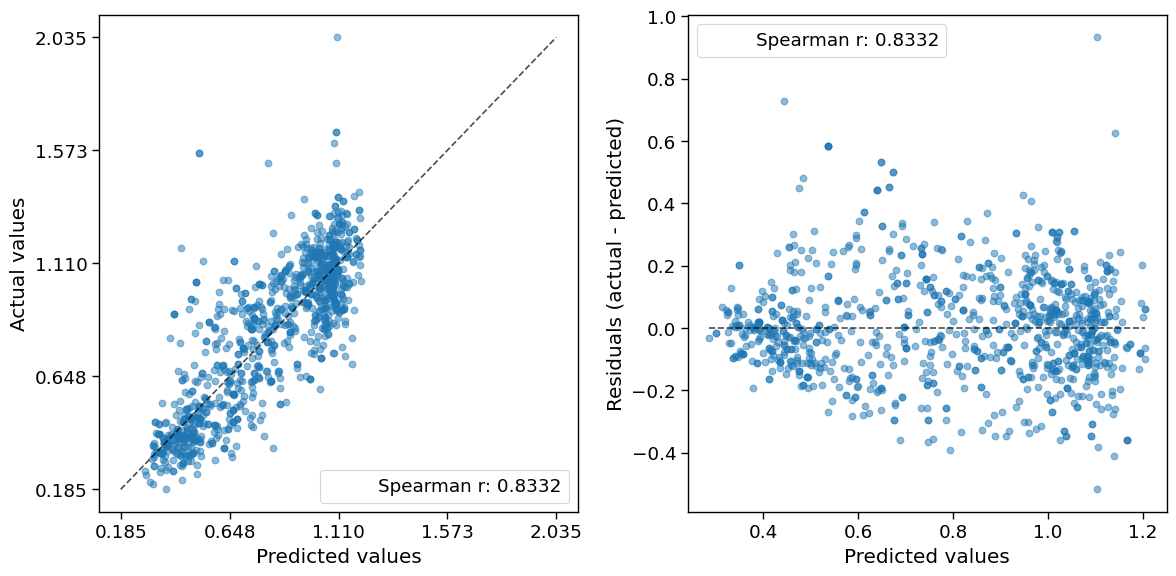

In [ ]:
from sklearn.metrics import PredictionErrorDisplay
fig, (ax0, ax1) = plt.subplots(figsize=(12, 6), nrows=1, ncols=2)

# plot actual vs predicted values
PredictionErrorDisplay.from_predictions(
    test_ds['labels'],
    predictions,
    ax=ax0,
    kind='actual_vs_predicted',
    scatter_kwargs={"alpha":0.5}
)
ax0.plot([], [], " ", label=f"Spearman r: {np.round(spearmanr.statistic, 4)}")
ax0.legend(loc="best")
ax0.axis('tight')

PredictionErrorDisplay.from_predictions(
    test_ds['labels'],
    np.ravel(predictions),
    kind='residual_vs_predicted',
    ax=ax1,
    scatter_kwargs={"alpha":0.5}
)

ax1.plot([], [], " ", label=f"Spearman r: {np.round(spearmanr.statistic, 4)}")
ax1.legend(loc="best")
ax1.axis('tight')

plt.tight_layout()
plt.show();

In [ ]:
# predicted fitness for first entry in test_ds
predictions[0][0]

0.8759765625

In [ ]:
# Actual fitness for first entry in test_ds
test_ds['labels'][0]

1.046729287808569

In [ ]:
# check to ensure test sequences are in correct order in test_ds
print(tokenizer(test_sequences[0])['input_ids'] == test_ds['input_ids'][0])
print(tokenizer(test_sequences[100])['input_ids'] == test_ds['input_ids'][100])

True
True


## Conclusion

We have developed two complementary approaches for sequence-to-function modeling using deep mutational scanning data: one relying on feature extraction and the other on fine-tuning. Typically, with a dataset of substantial size, fine-tuning tends to yield superior model performance compared to feature extraction. Regardless of whether the model is fine-tuned or based on feature extraction, it holds the capability to contribute to prospective design by generating sequence proposals through in silico directed evolution. The detailed exploration of in silico directed evolution will be the focus of an upcoming notebook.

In the context of model inference, it is imperative to prioritize scientific rigor over statistical outcomes. A thorough comprehension of the data generation process, acknowledgment of model limitations, and an understanding of the distribution within the inference regime are essential. Consideration of specific experimental details is paramount - the study's design, assay fidelity (distinguishing between low and high throughput measurements), data quality (with attention to sequencing depth in next generation sequencing measurements), and the alignment of the ultimate test data distribution with the training data distribution. It is crucial to refrain from falling into blind love with model's elegance and power, as expounded upon in the [previous notebook](https://github.com/arjan-hada/protein-variant-prediction/blob/master/00_protein_seq_to_fxn_model.ipynb). Instead, a judicious evaluation of the scientific context is indispensable for robust and meaningful model inference.

In this notebook, we fine-tuned a transformer protein language model using assay-labeled data, comprising protein sequence variants and their corresponding fitness values. The question arises: Can we fine-tune a transformer model in the absence of assay-labeled data? This intriguing possibility will be the focus of a future notebook.

Moreover, a more pressing challenge surfaces: Can we identify promising protein sequence variants for experimental validation when no initial experimental measurements are available? This will serve as the central theme for the upcoming notebook—zero-shot prediction of evolutionarily plausible and promising protein sequence variants.


In [ ]:
# Download final model from colab
!zip -r models/esm2_t12_35M_UR50D-finetuned-wtaav2-v0.zip models/esm2_t12_35M_UR50D-finetuned-wtaav2-v0/

  adding: models/esm2_t12_35M_UR50D-finetuned-wtaav2-v0/ (stored 0%)
  adding: models/esm2_t12_35M_UR50D-finetuned-wtaav2-v0/training_args.bin (deflated 50%)
  adding: models/esm2_t12_35M_UR50D-finetuned-wtaav2-v0/vocab.txt (deflated 6%)
  adding: models/esm2_t12_35M_UR50D-finetuned-wtaav2-v0/model.safetensors (deflated 7%)
  adding: models/esm2_t12_35M_UR50D-finetuned-wtaav2-v0/config.json (deflated 50%)
  adding: models/esm2_t12_35M_UR50D-finetuned-wtaav2-v0/special_tokens_map.json (deflated 49%)
  adding: models/esm2_t12_35M_UR50D-finetuned-wtaav2-v0/tokenizer_config.json (deflated 78%)


In [ ]:
# Download that zip file
from google.colab import files
files.download("models/esm2_t12_35M_UR50D-finetuned-wtaav2-v0.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>